In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Model Definition

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5):
        super(ActorCritic, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.actor = nn.Linear(hidden_size, output_size)

        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        logits = self.actor(x)
        action_probs = torch.softmax(logits, dim=1)
        state_value = self.critic(x)

        return logits, action_probs, state_value


Data Processing

In [4]:
final_data = pd.read_csv("/content/final copy merged.csv")

final_shuffled = final_data.sample(frac=1, random_state=SEED).reset_index(drop=True)

train_cutoff = 6678
train_df = final_shuffled.iloc[:train_cutoff].reset_index(drop=True)
user_df = final_shuffled.iloc[train_cutoff:].reset_index(drop=True)

X_train_df = train_df.iloc[:, :-1]
y_train_series = train_df.iloc[:, -1]

X_user_df = user_df.iloc[:, :-1]
y_user_series = user_df.iloc[:, -1]

le = LabelEncoder()
y_combined = pd.concat([y_train_series, y_user_series], axis=0)
le.fit(y_combined.astype(str))
y_train = torch.tensor(le.transform(y_train_series.astype(str)), dtype=torch.long)
y_user = torch.tensor(le.transform(y_user_series.astype(str)), dtype=torch.long)

X_train = torch.tensor(X_train_df.values.astype(np.float32))
X_user = torch.tensor(X_user_df.values.astype(np.float32))

print("Train shape:", X_train.shape, y_train.shape)
print("User shape:", X_user.shape, y_user.shape)
print("Classes:", list(le.classes_))
num_classes = len(le.classes_)


Train shape: torch.Size([6678, 64]) torch.Size([6678])
User shape: torch.Size([4999, 64]) torch.Size([4999])
Classes: ['0', '1', '2', '3']


Hyperparameters tuning

In [5]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = num_classes
learning_rate = 1e-3
pretrain_epochs = 50
online_epochs = 50
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

user_dataset = TensorDataset(X_user, y_user)
user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True)

model = ActorCritic(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)


ActorCritic(
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (actor): Linear(in_features=128, out_features=4, bias=True)
  (critic): Linear(in_features=128, out_features=1, bias=True)
)


Supervised Pre-training (actor with CrossEntropy)

In [6]:
criterion_ce = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()

print("Starting supervised pre-training (actor)...")
for epoch in range(pretrain_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        logits, action_probs, state_value = model(batch_X)

        actor_loss = criterion_ce(logits, batch_y)

        pred_labels = torch.argmax(logits.detach(), dim=1)
        critic_targets = (pred_labels == batch_y).float().to(device)  # shape (batch,)
        critic_loss = criterion_mse(state_value.squeeze(), critic_targets)

        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += (pred_labels == batch_y).sum().item()
        total += batch_y.size(0)

    avg_loss = epoch_loss / len(train_loader)
    acc = correct / total
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Pretrain Epoch [{epoch+1}/{pretrain_epochs}] Loss: {avg_loss:.4f} Acc: {acc:.4f}")

torch.save(model.state_dict(), "pretrained_actor_critic.pth")
print("Pretraining finished and model saved to pretrained_actor_critic.pth")


Starting supervised pre-training (actor)...
Pretrain Epoch [1/50] Loss: 1.6703 Acc: 0.4190
Pretrain Epoch [5/50] Loss: 0.4904 Acc: 0.8467
Pretrain Epoch [10/50] Loss: 0.2055 Acc: 0.9386
Pretrain Epoch [15/50] Loss: 0.1329 Acc: 0.9624
Pretrain Epoch [20/50] Loss: 0.0966 Acc: 0.9738
Pretrain Epoch [25/50] Loss: 0.0930 Acc: 0.9765
Pretrain Epoch [30/50] Loss: 0.0634 Acc: 0.9823
Pretrain Epoch [35/50] Loss: 0.0534 Acc: 0.9856
Pretrain Epoch [40/50] Loss: 0.0571 Acc: 0.9843
Pretrain Epoch [45/50] Loss: 0.0770 Acc: 0.9828
Pretrain Epoch [50/50] Loss: 0.0475 Acc: 0.9865
Pretraining finished and model saved to pretrained_actor_critic.pth


Online Adaptation (actor-critic RL using correctness reward)

In [7]:
model.load_state_dict(torch.load("pretrained_actor_critic.pth", map_location=device))
model.train()

optimizer = optim.Adam(model.parameters(), lr=learning_rate * 0.5)

def compute_rewards(actions, labels):
    rewards = (actions == labels).float() * 2.0 - 1.0
    return rewards

print("Starting online adaptation (actor-critic RL)...")
for epoch in range(online_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in user_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        logits, action_probs, state_value = model(batch_X)
        dist = torch.distributions.Categorical(action_probs)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)

        rewards = compute_rewards(actions, batch_y).to(device)
        adv = rewards - state_value.squeeze().detach()

        actor_loss = -torch.mean(log_probs * adv)
        critic_loss = criterion_mse(state_value.squeeze(), rewards)

        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (actions == batch_y).sum().item()
        total += batch_y.size(0)

    avg_loss = total_loss / len(user_loader)
    accuracy = correct / total if total > 0 else 0.0
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Online Epoch [{epoch+1}/{online_epochs}] Loss: {avg_loss:.4f} Accuracy: {accuracy:.4f}")

torch.save(model.state_dict(), "fine_tuned_actor_critic.pth")
print("Online adaptation finished and model saved to fine_tuned_actor_critic.pth")


Starting online adaptation (actor-critic RL)...
Online Epoch [1/50] Loss: 0.1006 Accuracy: 0.9162
Online Epoch [5/50] Loss: 0.0815 Accuracy: 0.9382
Online Epoch [10/50] Loss: 0.0743 Accuracy: 0.9502
Online Epoch [15/50] Loss: 0.0628 Accuracy: 0.9560
Online Epoch [20/50] Loss: 0.0566 Accuracy: 0.9570
Online Epoch [25/50] Loss: 0.0595 Accuracy: 0.9616
Online Epoch [30/50] Loss: 0.0608 Accuracy: 0.9674
Online Epoch [35/50] Loss: 0.0574 Accuracy: 0.9618
Online Epoch [40/50] Loss: 0.0493 Accuracy: 0.9676
Online Epoch [45/50] Loss: 0.0461 Accuracy: 0.9718
Online Epoch [50/50] Loss: 0.0414 Accuracy: 0.9734
Online adaptation finished and model saved to fine_tuned_actor_critic.pth


Evaluation on user/test data

Evaluation accuracy on user set: 0.9830


<Figure size 600x600 with 0 Axes>

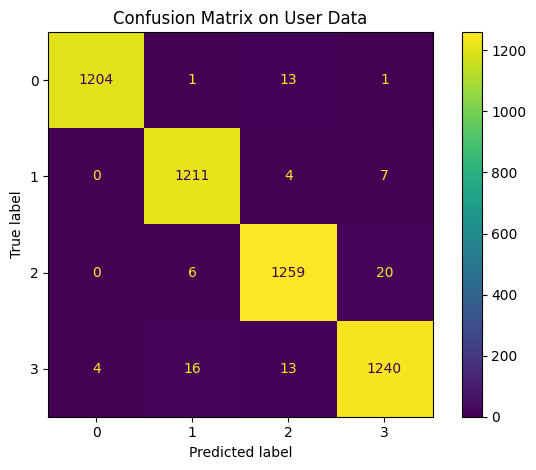

In [8]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y in user_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        logits, probs, _ = model(batch_X)
        preds = torch.argmax(probs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_true.append(batch_y.cpu().numpy())

if len(all_preds) > 0:
    preds = np.concatenate(all_preds)
    true = np.concatenate(all_true)
    acc = accuracy_score(true, preds)
    print(f"Evaluation accuracy on user set: {acc:.4f}")

    cm = confusion_matrix(true, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    plt.figure(figsize=(6,6))
    disp.plot()
    plt.title("Confusion Matrix on User Data")
    plt.tight_layout()
    plt.show()
else:
    print("No user data to evaluate.")


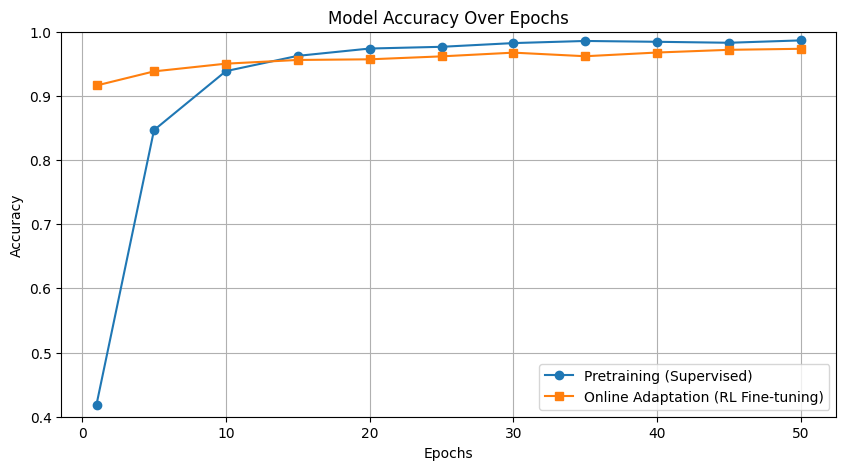

In [5]:
import matplotlib.pyplot as plt
pretrain_acc = [
    0.4190, 0.8467, 0.9386, 0.9624, 0.9738,
    0.9765, 0.9823, 0.9856, 0.9843, 0.9828,
    0.9865
]
pretrain_epochs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

online_acc = [
    0.9162, 0.9382, 0.9502, 0.9560, 0.9570,
    0.9616, 0.9674, 0.9618, 0.9676, 0.9718,
    0.9734
]
online_epochs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

plt.figure(figsize=(10, 5))
plt.plot(pretrain_epochs, pretrain_acc, marker='o', label='Pretraining (Supervised)')
plt.plot(online_epochs, online_acc, marker='s', label='Online Adaptation (RL Fine-tuning)')

plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.grid(True)
plt.legend()
plt.show()
